# Goal of the project

The goal of this project is to control a 2D quadrotor to get it to perform acrobatic moves. The controllers will be designed using the iterative LQR (iLQR) algorithm.

## 2D quadrotor

The quadrotor is depicted in the following figure <img src='quadrotor.png' width="300">
The quadrotor model is written as
$$\begin{align} 
\dot{x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\ 
\dot{y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $x$ is the horizontal and $y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $z = [x, v_x, y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the class ```Quadrotor``` that provides all the useful information about the robot and methods to simulate and animate it as shown below.

Please write the answer to all questions that are not asking for code in the report (as a single pdf file). Please submit your code as runnable Jupyter Notebooks (one for each part) or as runnable python scripts.


## Part 1 - Setting up
1. Discretize the system dynamics using the Euler method seen in class - write the time discretization step as $\Delta t$ (use symbols not numbers for the mass, etc)
2. Assume that robot starts at an arbitrary position $x(0) = x_0$, $y(0) = y_0$ and $\theta(0) = 0$ with 0 velocities. Compute $u_1^*$ and $u_2^*$ such that the robot stays at this position forever after (you may test your answer using the simulation below).
3. Analyzing the system dynamics, is it possible to move in the x direction while keeping $\theta = 0$? Explain why.
4. Analyzing the system dynamics, is it possible to have the system at rest with $\theta = \frac{\pi}{2}$ (i.e. have the quadrotor in a vertical position)? Explain why.


## Part 2 - LQR to stay in place
Now that we have $u^*$ capable of keeping the robot at rest, we can design a simple controller that ensures that the robot stays in place even when pushed around by random disturbances (e.g. due to the wind). Our task here will be to design a LQR controller that keeps the robot at a predefined position. Since the dynamics is not linear, we need to compute a linear approximation of it.
1. Linearize the dynamics at an arbitrary operating point $\bar{z}$, $\bar{u}$ and write the linearized system dynamics using the variables $\hat{z}_n = z_n - \bar{z}$ and $\hat{u}_n = u_n - \bar{u}$.
2. Write a function ```get_linearization(robot, z, u)``` that returns the matrices A and B given a robot (object of type ```Quadrotor```), a state z and a control u.
3. Using the linearized dynamics, we can design an infinite horizon LQR controller of the form, $\hat{u} = K \hat{z}$ to stabilize the resting point. What will be the actual controller in the original coordinates $u$ as a function of $z$?
4. Design such an infinite-horizon LQR controller to stabilize the origin $z=0$ and test it using the simulator below (Explain your intended design in the report, including the cost function and found control law). In particular, verify that it can handle perturbations by calling the ```simulate``` function with ```disturbance = True``` (when setting disturbance to True, the simulator will generate a random perturbation every 1 second). Simulate your controller for 10 seconds, plot the state evolution and show the animation (show the plots in your report).


## Part 3 - following a trajectory using linearized dynamics
Now we want to follow a given trajectory leveraging a linearized version of the dynamics to design LQ controllers.
1. Assume that we want to follow a circle of radius 1 centered at (0,0) while keeping an orientation $\theta=0$, how does the linearization of the dynamics change along the desired trajectory? Why?
2. Design a tracking controller (using an LQ design) to follow this desired trajectory (Explain your design in the report). 
3. Test the tracking controller with the simulation (with and without the perturbations) and verify that you can indeed track the (x,y) trajectory very well. Are you able to also track $\theta$? (Explain) Analyze your results (including plots of the states, controls, etc). What benefits and issues do you see with this approach?


## Part 4 - iterative LQR
Now we would like to do more complicated motions with the robot, like a flip. In this case, we do not have a prescribed trajectory but we would like to compute a locally optimal trajectory together with the controller. We will design an iterative LQR algorithm to solve this problem.
1. For the first task, we want the robot to reach a vertical orientation $\theta = \frac{\pi}{2}$ at the location $x=3$ and $y=3$ at time $t=5$ starting from $z_0=0$. During the rest of the motion, the robot should try and stay close to the origin. It should also try to keep its control $u$ close to the control needed to keep the robot at rest. We want to make sure the robot reaches the origin $z=0$ at the end of the movement. Find a time-varying cost function that promotes such a behavior (use only quadratic/linear terms for simplicity). Assume $T=10$ seconds.
2. Write a function ```compute_cost(z,u, horizon_length)``` that returns the cost of a trajectory z with control trajectory u.
3. Compute the quadratic approximation of your cost function along a trajectory $z_n$ with control trajectory $u_n$ (this is not just your cost function!)
4. Write a function ```get_quadratic_approximation_cost(z, u, horizon_length)``` that returns the quadratic approximation (Hessian matrices and Jacobians) of the cost function when approximated along the trajectory z with control trajectory u.
5. Write the iLQR algorithm that solves the problem using the functions written above. At each iteration, for the line search, start with $\alpha = 1.$ and decrease it by half when the cost does not improve (you can stop when $\alpha < 0.01$).
6. Test the algorithm using as initial guess $u$ such that the robot is at rest (cf. Part1.2). Analyze your results (probably you will need to "tune" your cost function), plot the initial and final state and control trajectories, show the animation. (use the simulation without perturbations for simplicity). What benefits and issues do you see with this approach?
7. Use iLQR (and a new cost function) to get the quadrotor to do a full flip, trying to reach the upside-down state $x=1.3$, $y=3$ and $\theta = \pi$ at $t=5$ and upright state $x=3$, $y=3$ and $\theta = \pi$ at $t=10$. Analyze your results. What benefits and issues do you see with this approach? Could you run the resulting controller on a real robot?

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

import quadrotor

In [2]:
# we create a robot
robot = quadrotor.Quadrotor()

# we can get its mass, half length (r), gravity constant
print(f'm is {robot.mass}')
print(f'r is {robot.length}')
print(f'I is {robot.inertia}')
print(f'g is {robot.g}')

# we can also get the integration step used in the simulation
print(f'dt is {robot.dt}')

# we can get the size of its state and control vector
print(f'number of states {robot.ns} and number of controls {robot.nu}')
print('the states are indexed as follows: x, vx, y, vy, theta, omega')

m is 0.5
r is 0.15
I is 0.1
g is 9.81
dt is 0.01
number of states 6 and number of controls 2
the states are indexed as follows: x, vx, y, vy, theta, omega


In [3]:
# we can simulate the robot but we need to provide a controller of the following form
def dummy_controller(state, i):
    """
        the prototype of a controller is as follows
        state is a column vector containing the state of the robot
        i is the index corresponding to the time step in the horizon (useful to index gains K for e.g.)
        
        this controller needs to return an array of size (2,)
    """
    # here we do nothing and just return some non-zero control
    return 1. * np.ones([2,])




# we can now simulate for a given number of time steps - here we do 10 seconds
horizon_length = 1000
z0 = np.zeros([robot.ns,])
t, state, u = robot.simulate(z0, dummy_controller, horizon_length, disturbance = False)

<IPython.core.display.Javascript object>


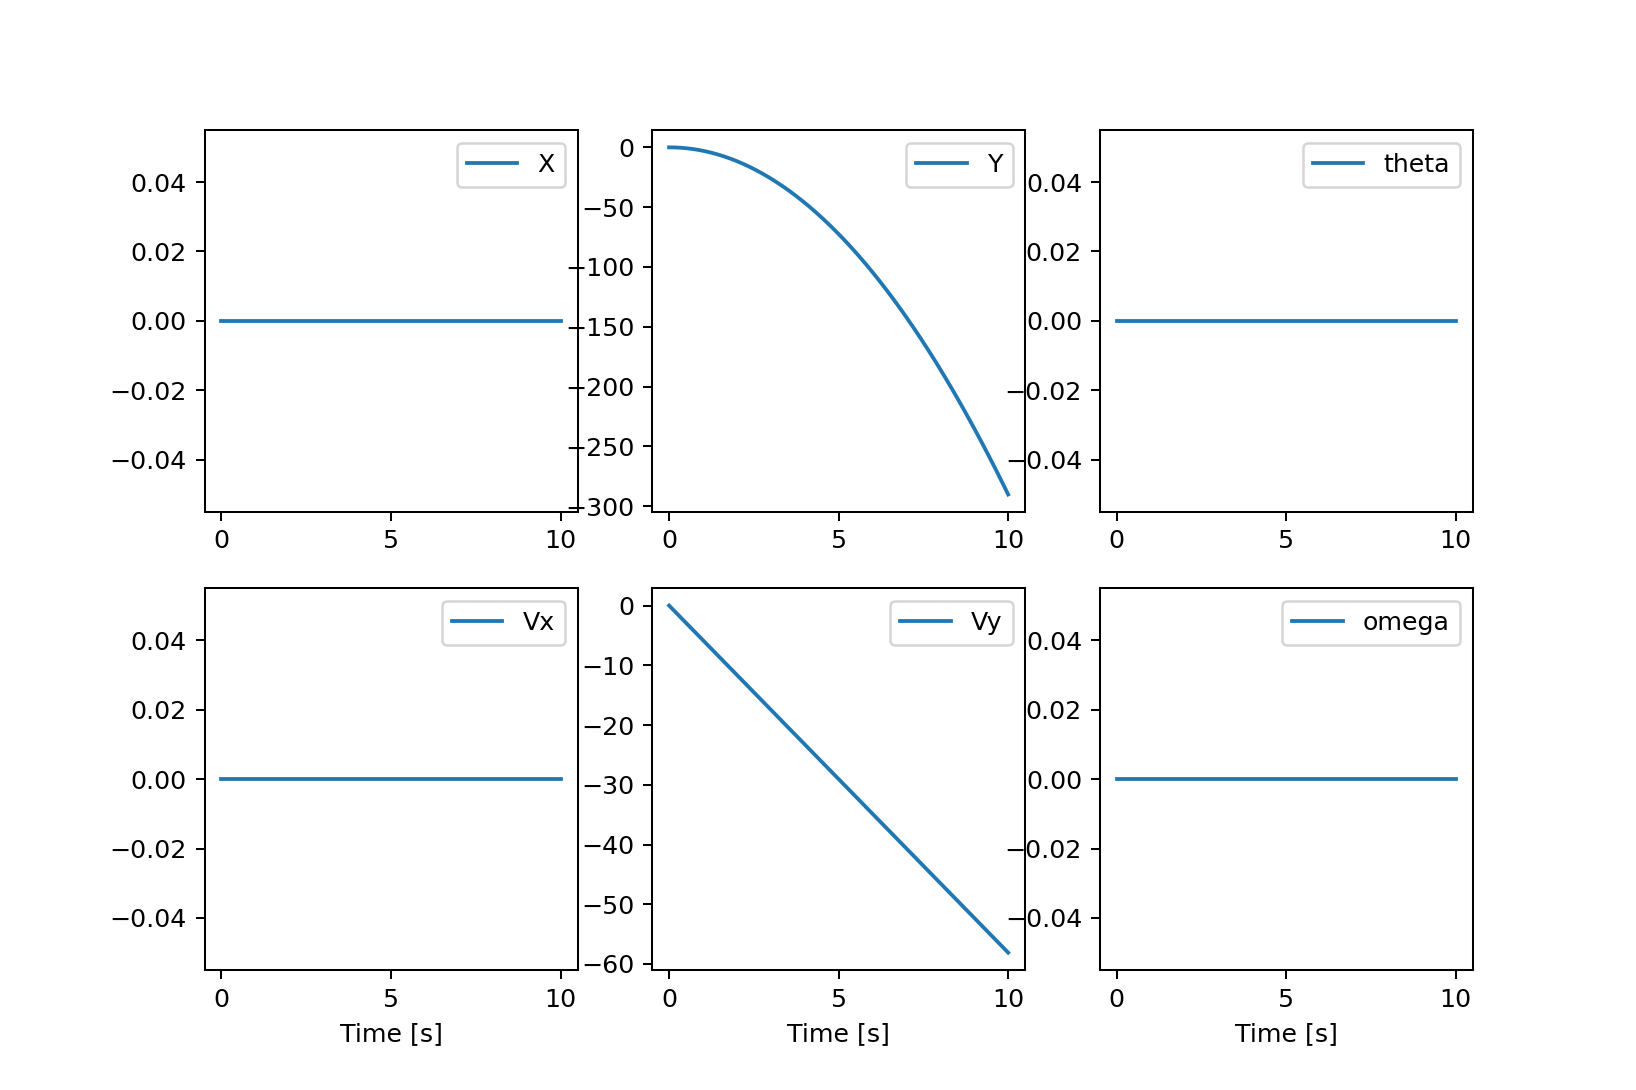

<IPython.core.display.Javascript object>


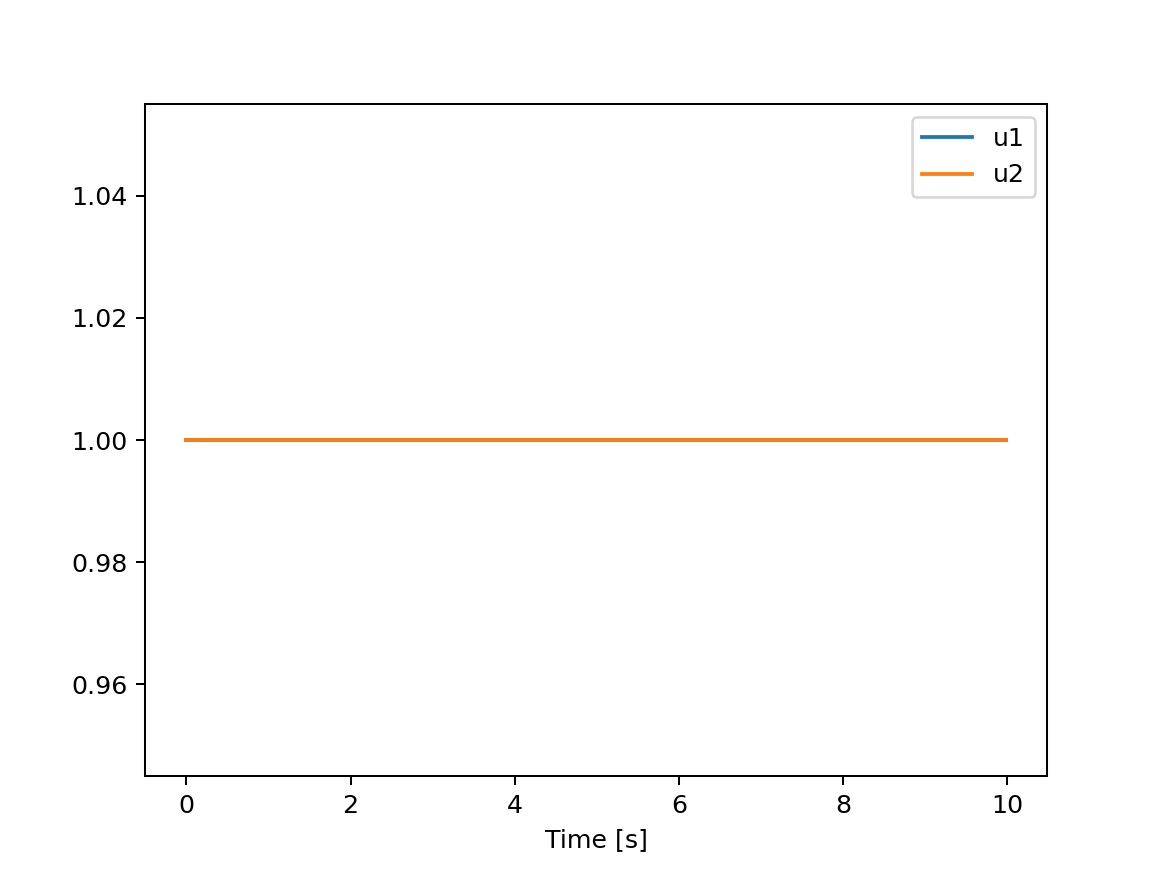

Text(0.5, 0, 'Time [s]')

In [4]:
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

In [5]:
# now we can also create an animation
robot.animate_robot(state, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAKiZtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzAyNyA0MTIxMjc3IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMCAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
Ed5liIQAEf/+94gfMstp+TrXchHnrS6tH1DuRnFepL3+IAAAAwAAAwAAAwAKklieIofxeM38AAAD
AAC3gBewDCAKqAwqPoh2d2dPMAiJHr46cNtWROOk97EYcuOhdjfSGRcSFIT2QQogk1usCkIjgbve
KEdmLhPUrWKiDlZzSnqksdOELAKadiFKpilhtOjafm1mOX1J6uxzeubFMJTVobl6NaV/ZmIE+0nq
+5kR/oUJY96SuN/eI7GD2dh4ALf/96RonpS6nykSdfvgC0XmaI8JeYZinVWAiUyFuUoTV/lcuXFv
UdRea4b58SAMIAk2CCtJYygVVLw4WloMMy9I7rimbOHq8cOgq1+ZwDiLXa5SyHuvA1l78Ejsj2gZ
MFMLKBcJkjXVkvHvH6xWuDDq3jCLMfOhTIvzmnGdaE/vYVZrpQqE5tWlH1wLzpsCVXhaMhwyKlIH
YXCzI57hRhGXk5AJs78oL3L0uFd6c/RFa7OFV/kuFKHj+kqM4DOAC+AogC3TkRHo8j5JpTvKiQM4
nLDD+XAg9NeD6W8cce2l/FR62IVTJaZmpZXtWP3P3BP8Aty1kv38ceunYStFyA/05L8hPnpct8Gw
CWlzTtbCvTReEHJz1a5gtpTABNPy+/tCuvMR6NespWG0p7CyRuLmGbFrumaxNIkG9KkVnPRNmHgd
6Nja5fMRXL/KzUgue9AcU+4R5HefIieerLQoi6JWGfJk0U/M/4r+bVg79kx5/PZG/sILjtN5sxv+
tpj/PnfjHr/N6428OJ8Xe/ix/s8Gs+Y7jHX/x71zNEg5rNgi2YiqO0/qmpK/bwVSWeDc4ImjrW51
6ab+J9G1i+iUHgFyt46k5v8oI9C90chDyBhHPXnRW4JNRZXMshGI0maTw1BGWtulXJtewiZf7Rph
FzeLI36mgISwmAgtQfYPheRynmluFENTAAADAAADAAADAAAE/itllAK02lkiq7QCOngzpQuNUKyt
364BwwOk5Ie/w8MbGGom4ulIJ1vjfXaxCY1cbyOLKQodE6fXjW/VACP5JofQ2I5ZinRIFqnUdz81
zhLgpHVN8/65TLuCDtsloS9CP7qdxbt3oZXI1vAYun/zlxN+xeeEL2jwJQhW0RpR1RYQefX0D/51
lGgQvqvTcEtcZFzhDuxZN4/+ZmB4NzANVtCyLwF70CIUCDtfrnMQVhM94uNfUoZHgTZu0Lrw7IMI
IbfbVotkyKbw2ErxZBn6k1yateQ1PGz7sTEkA1RBJAbSyVb2/8it5yZoT5owUUZHIqMf9SOmf57X
m8KVEgHydxwNkKAlC+9sgG2G9tDMYAY8/yscnH5d9k4liJUs7G+fYO5M6tJUDFMeP4JSnj/LgAAD
dGYTYgAR8OVDUAFeY15UAZltjnplzXOHKLkLbhvTk9IUHxj4SCCiGYjFxmG/GWAoNFjyaUKosfvE
Sbn/+E4TZ0nN+XYOql39eHNl962no9rsn0PoyrBe9aufoG0vjwaG35408wvw5ZW10VxKgk9NgoG9
FllLmRk5EDi3KeVx4D5MYRMbYKm10Agtkm9CK1rYD4K2pbrV5Y7rdCUOzdca8j7zOTaaOUQBXzdP
CvL2XfAi8nY863Genq27ny2bvgGfw1dlWoEKJEnZmSSb1ItRr8wRD2FxNgbSfLQ3dpOzWaMKUxug
YdYM2ckNX0aG5jxaz0bHK+9t1riYxuFSlQ3JyUL2s6BAsnO+hgxguFd3WgbiMjj66Uhy9S0/9RM+
u7qPHCuSWYqQPPJidABhQu5KGY20H9aRj53Eyq6PGkO20sQZrD3e40xV4n3fxe/47oCD75nBK21G
E6SXkg041CCPZu7T7uPA0QdDNOS3nCSSJ65dIZ82PYB1fG1eJhBIp/yxFyJLzM0AAA/7PJgAABvo
pQIACxzAGCzz+cXQPLKgXYCqDtlLpwfgE15gb8X5axSPoE9u/6PpfJDVs0lO0JILrXHumIfm0r+B
U/l/R5Rf1jC6huqkKc7TTT+6pekZLkiUrYvuCKH5nMSyLFzVb4o+/9zDrQyYcSE1As4+NFVmbAyK
W7MA/s2lDIIjjz2I+StYYZKprpRwrqVvA96mqP+UkV9nbpvjaF2ppaes6VH0lXDzN9D8B8wq5Ab1
4Eq6xFaxz8+E00uY5jDgYKS6iKOD3Ce2cnFn+8T6vAFuwc/PuusqV2hvTOqhNcsg0LJaZ+Gf4Qj3
DmlGz/sNcLCMbQ2UYyEjAwBwTJcoa8QlS1pJkjRVFaBkZol436mGvGuF6cubDR4fy++8GxhAmHSa
Y/f2uaBpHqpovKP0xDBLuAVNQnQgY+CiURPkpH4ekgDu+GctW8c+YZ9DZ8GgduMp9K8mCYsA/ox/
/pHrHijU6puiXEJN4WsG/RXAUZc8zNOHY77p8vpf9+kA6Wr5STOFdbzvFIK/igZWKl+6/XqVokQK
Zv2dnmD8rfwX0wANBa7kXD7pCyPBwvm4pEUMSEX9cHD7dioyeEj9VtM9Fk7HIzvkV+AGm1vGZI+H
d9A+XqVnKxAmYYE/df+kYdxmOeS2YNObvl5p5Ck1W4PLgZfoNvUwsSf55Hc/cULPV1x+vpd090gH
wtXUWLgqfRIiMaICwea5O1maTDp7SWBlIFL8VA6LZjAuLLn8utGI/bHMAAAGubJfKE263/HuKz0u
5oAAAAMAAZgJ98xgjRNwxzi1F77f1fBMtY6Qyo9pCFyIGpJLC6CrYE1kVf1XlVn/u5DKYt6cyOa5
p3brAItRJxrp3EBIU7W4cipOA/IJdcNzKogQPzAg0QsJKRfMv3imyBekvtoNPLw/0QPfGv7CgzLI
1TCUdMs9Qy3pUXtt6eG2IfZAK7nGxZw9zxZCsGuOlkb1O7VhEGan16TQMVibduRqGd5Ed777EoV8
LjORFeHneWTPMAyGud8BV

<IPython.core.display.Javascript object>


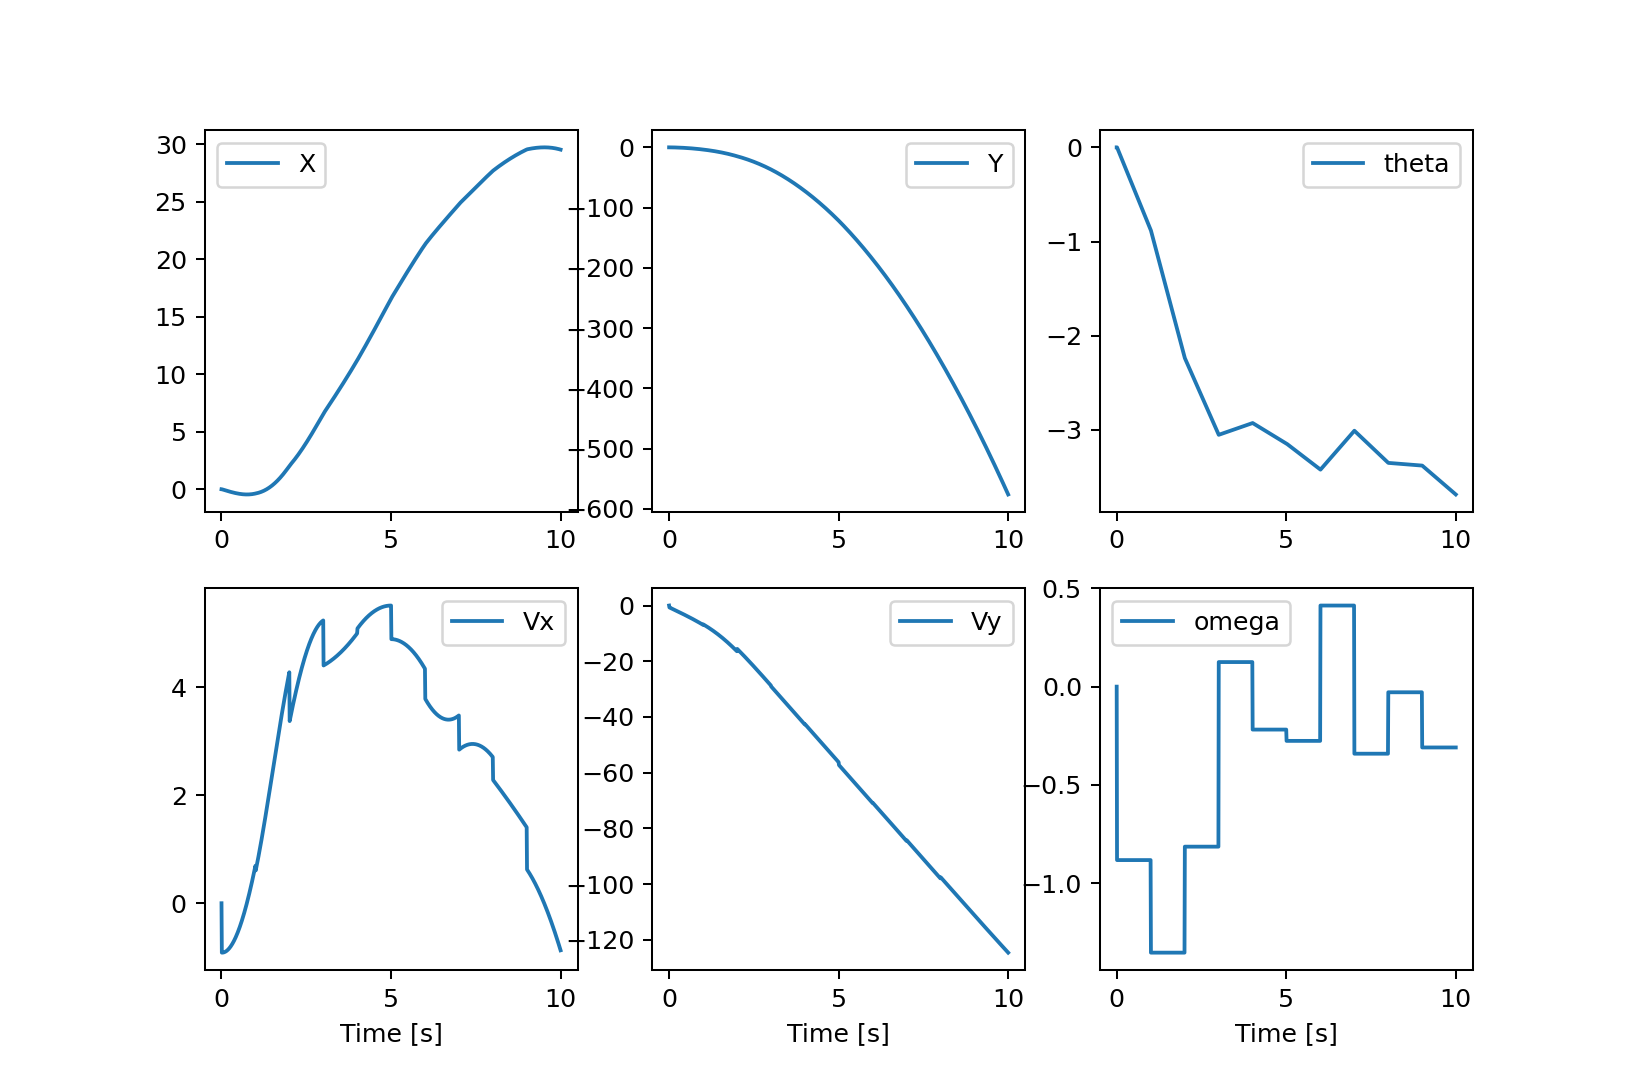

<IPython.core.display.Javascript object>


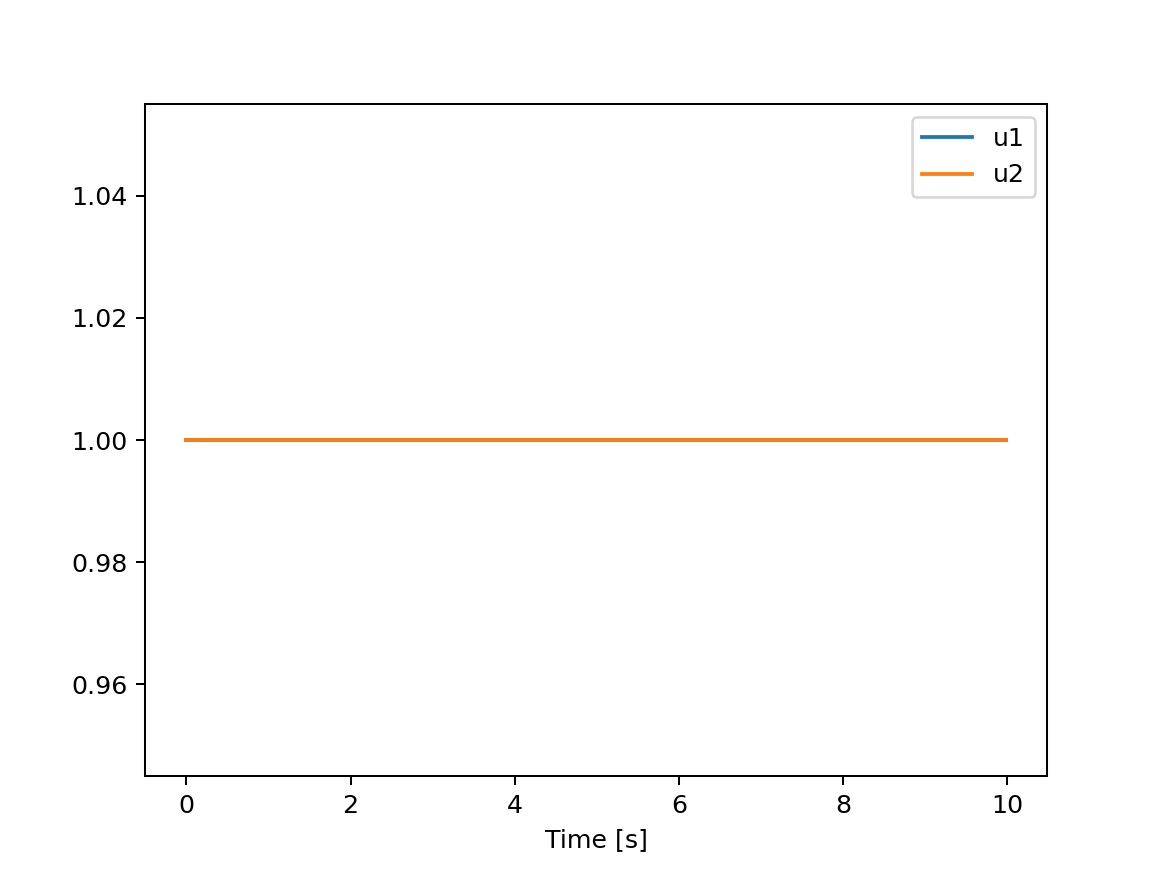

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAL8ttZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzAyNyA0MTIxMjc3IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMCAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EaNliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAADAAB1oWGAKYNX0WHAAAAD
AAmgAVAAowCUgKmhHu/ifulxAQcwg58Gg9IQ//ND6pvzvVm0S1gLeifirHZOZuMa+DWBSERwDJuK
Rls1wwiJr4cof7z2cZAmI629h/13RClUxSw2nWg78hfTSbAu/R33AELAxpF7tz+7C/Wc42llJd7/
jv5/5eyIvbVaeliyk24erZdh5JiZfSMmPlin8lZoaDeZVoIFfNLV0B+RvVg9N/oaI3qY3rh/eida
Al3Gi14ub56yDcIAk2CCtI4ygVRpEaiQyJpGS8sDimLBPq8YKec1+MfgMDjRhPBSoas+Aj8CjcvV
M2MKYUr9QTodafJePeP1etcGE2uUr2Y9LJYU1a6c5h9D/BrJuuk+dyypTVqWVFSMibVjKAC9MW6l
ECIMouTPcIcyHY5QCVik4VHbOSY5AjTyk1HCtCRAY15fjHMHfj9FucwFQAEEAAAEaVoMnzvoz8Ze
2jxHsdyww/lwIPhYZj9cr/sCzDGA1JXOpktMzUsr2rKk2ZDKOAW5ayX7+OPXXeNVyPAf6cl+QoDD
6XmjYBLS5p2thcV6nvSE56tcwW0qgnT7Bkr/3EgFlC2Gmcq9VVEMzSTnjDNi13TNYmkTjaMClYZr
pYzoHejY2u3pMNP/q6PSJQbiA8VzfdY30q2gf0DHsVXRKw3GSam1DkB3jZwwE6vysr57I39hBcdp
xEnQi97R/1J34x6EpF5vGwb3Z0WP9ng1nzHcZNPdPl5nmhYqn3Emb9/tHaf1TUlft4MWLhnZchpo
8kk7V1rA89/axfRKDwC7UViR+Hd/DN0iXmPdPs+yhRzorcEtANHXTyOiKu+AKBG5ykWbCJ85PQoH
+x3IRc3iyLcLia0HLJ1k11k+F5HKec7CFUekAAADAAADAAADAAA0fdssoBX3TUWcPai5p4M6ULjV
CsreA+QcMDpOSHv8PDGxhqRuLpSCdb49V2sQmNXG8jiykKPdOn141v1QAj+SaH0NqOWYp0SBap1H
c/Nc4WwKR2EPN/5+EpTVOWS0JehbdtpAA8SnkQOC3gMXo/5qsmPYvPCG6m4IzgkJyF+PAqzsJKKB
/86yjQIX1XgAR8EViZwhPY0m8f/MzA8G5gGq29s14cI2XhcBrKSkNF/Ur2hFN/HOlDI8CbN2hdeH
YbhG4R0JwvZMim8NhK8WQZ+o0ekvdkNT4cC+0xJANUQSQG0slW9v/ErD/7Mk+a3Qq4P3yjH/Ujpn
+e15rilTeB8nccEZCgJQvvbIBthvbIzGAGPP8qbVd+Vg6T2bOKlnY3z7B3JnVpHu/P0gEAAAAwAA
AwAAAwAAzbbHPTX2RrklWReD6nRTnif/zzwkEFEMxGLjMN+NMBQaLHk0oVP8VulD1Gf8JxmzpOb8
uwxvRZqDyhGnc13C1nNQ+I6vRTYxPM04i1/WzeWmqwkFGWECrXBtENewr244icOGmIcbGoE45Fuc
8rjwHyYwiY2wVNroBBbJN6EmMWwHwVtS3XLyx3W6Eodm6415H3mcm0904FyF52ote7W6wMlodCIg
99x4zvpavEEo7IghwzrhOVQNGMkaTE0/TDZyx7LHwJ9lP3hxnIhlX7gMnYyqu32iAlPjfvTM0/PJ
OCjHXJHkniK+/dw6HxlY2wkNlm+dlAc99j/Wtc2QNXCKcXvXSGY9GiPY8DEYAX+AEK61FELarH5t
MLik0gFb1z80Umz/JMQ0yMpMaJlcMtd3K7/ozOpVhmVMVeJ938Xv+O6AhC+ZwSttRhOkl5SOONL1
D4ypoS+hjP/6PNmmB1FlyBCOdkj7S3ELK57vSPvfvAAAAwAAAwAAAwFQlFe60PpZqZrAiQYDGbPp
OvdlThOGmfQtX+S6j1Tc8qnaEkF1rj3TEPzaV/VKfy1uLGl7itt6JgWQvuDs2230sWDm/1L0fNtG
/aDTnJ2cEzNpIbYUC+TVvltAoH4xZx8aKrM2BkUt2km/c6SDMRHjz2IoOh9urFqQsGMOPkkENBmC
lbb+c2duIEt+Xamlp6zpUfSVcSsq02QHzCh5jVO0luQqgiRWsc/PhNNLn4coZ1tSp0GHAwUmHMbJ
rqtRTpG451KA/a4wNvzdfRzdwWejuP3mMkgt41SioviPpfbXm18QO5zA/pnYUR5iFXKEBCaCW9f+
HonTgtdSL7BCEX87tGCKGjECI3oIbzHb5xStIFlSsbiSSqumJ2k1gofBb5Y+2GUCzCih6bL61qAq
XyY7PxxsS1ChkU322pX0Lu3uXQj60zA62CXrdydaTwIi6MJdMdhrVpM2j/pZVde4nY6+ji2loHzl
4C7sqrOB2U+cJFl1NSrh4Q//HP8jfManoIRhuHNwUDMwfUeN4+Y6O9GPOvfbsRiSXON4HCKKMBpc
aIIKgiBJ1eMnBFNmkF7gqsLzMsdXENFnLIREJYHfdf+Z2mSd5pMDnxpOoa4OqCPqFn7UKrQtw8Kf
GnBGdrCl0/WZQu2a7YmsPQ6VzHP2oWp03zLq7LU+7n+7p5O3v2IWAIupg644vXKBPmZx/AAADW0r
GJ4KNSR/UEzYngACstF/90YPcaIagAAHRcuX76zPJW0cn6l3Ap0OM6cquiXOR6JEUWJGSK+1kneL
DNxtV60bgHGDoX6zQ5n17d7loPs9cIRzZZ4MH98c+W8yyXvy/MILPsNra2hdlztQ1I7R06wRaueY
iaUfdKl7uc0oVn5yd21s8nBRUD7Tpk49hfEadq+1qZ+lJJ9TKl/bfrolTle6kJ3lyDH7w5WLjEzw
H5cIqbmhaXex5yCBZa2rtrKX8KkPnCH/hB9p6zAw6IA45OPLMXwArKqLvrQcGDj/wUmwGM0OPJJW
fOFmNZ3vENBlfKyvMfJl9

In [6]:
# we can also simulate with perturbations
t, state, u = robot.simulate(z0, dummy_controller, horizon_length, disturbance = True)

# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

robot.animate_robot(state,u)